In [3]:
import pickle
import shutil

import numpy as np
import matplotlib.pyplot as plt

from ent_data_simulation import params_injected

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

Optional mpi4py package is not installed.  MPI support is not available.


## Load pulsars and PTA object

In [4]:
# load Enterprise pulsar objects
with open('ent_data_simulation/data/enterprise_pulsars.pkl', 'rb') as f:
    psrs = pickle.load(f)

# load Enterprise PTA object
with open('ent_data_simulation/data/pta.pkl', 'rb') as f:
    pta = pickle.load(f)

for psr in psrs:
    print(psr.name)

J1312+0051
J1909-3744
J1455-3330
B1953+29
J0709+0458


In [5]:
# load injected parameters
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
x_inj_dict = data_dict['x_inj'].item()

In [6]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1312+0051_red_noise                     FourierBasisGP                 2                   

params:
J1312+0051_red_noise_log10_A:Uniform(pmin=-18.0, pmax=-11.0)                              
J1312+0051_red_noise_gamma:Uniform(pmin=1.0, pmax=7.0)                                    
__________________________________________________________________________________________
J1909-3744_linear_timing_model_svd       TimingModel                    0                   

params:
_______

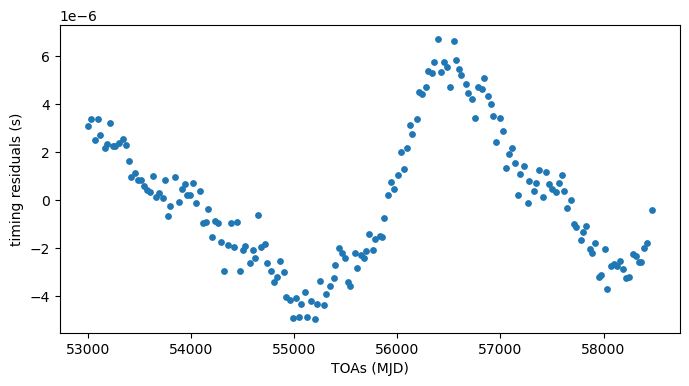

In [7]:
# plot timing residuals
psr_ndx = 2
plt.figure(figsize=(8, 4))
plt.scatter(psrs[psr_ndx].toas / 86400., psrs[psr_ndx].residuals, s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')
plt.show()

## test Enterprise likelihood

In [8]:
def get_dict(params):
    return {param_name: param for param_name, param in zip(pta.param_names, params)}

In [9]:
# likelihood function
def get_lnlike(params):
    return pta.get_lnlikelihood(get_dict(params))

# prior function
def get_lnprior(params):
    return pta.get_lnprior(get_dict(params))

# posterior
def get_lnpost(params):
    return get_lnprior(params) + get_lnlike(params)

In [10]:
x_test = np.array([param.sample() for param in pta.params])
print(get_lnpost(x_test))

9347.630940182704


In [11]:
%timeit get_lnpost(x_test)

442 μs ± 5.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
# # psr_dists_inj, psr_dist_stdev = np.load('data_simulation/data/psr_dists.npy')
# def ln_prior_CW(psr_dists):
#     return -np.sum(np.array([(dist - dist_inj)**2. / (2. * stdev**2.) 
#                     for dist, dist_inj, stdev in zip(psr_dists, pta_dict['psr_dists'], np.ones(len(wrapped_psr)) * 0.2)]))

In [13]:
# num_psrs = len(pta.pulsars)
# def ln_prior(params):
#     psr_dists = params[:4 * num_psrs][::4]
#     return ln_prior_CW(psr_dists)

In [14]:
# # plot cross section of the likelihood over one parameter
# # other parameters fixed at injected values

# param_index = 0
# num_pts = 100
# param_vals = np.linspace(x_mins[param_index], x_maxs[param_index], num_pts)
# likelihood_vals = np.zeros(num_pts)
# for i in range(num_pts):
#     params = np.copy(x_inj)
#     params[param_index] = param_vals[i]
#     likelihood_vals[i] = get_lnpost(params)


# plt.plot(param_vals, likelihood_vals, color='C0', label='ln(likelihood)')
# plt.axvline(x_inj[param_index], color='red', alpha=0.7, label='injection', lw=4)
# plt.axvline(param_vals[np.argmax(likelihood_vals)], color='green', alpha=0.7, label='maximum', lw=2)
# plt.xlabel(pta.param_names[param_index])
# plt.legend()
# plt.show()

## MCMC

In [15]:
# set up the sampler:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)
cov = np.eye(ndim) * 0.01
outDir = 'enterprise_chains'


sampler = ptmcmc(ndim=ndim,
                 logl=get_lnlike,
                 logp=get_lnprior,
                 cov=cov, 
                 outDir=outDir,
                 resume=False)

# sampler for N steps
num_samples = int(1e6)  # normally, we would use 5e6 samples (this will save time)
sampler.sample(p0=x0,
               Niter=num_samples,
               # SCAMweight=30,
               # AMweight=15,
               # DEweight=50,
               )

# store chains in compressed binary format
print('Loading chains.')
chains = np.loadtxt('enterprise_chains/chain_1.txt', skiprows=int(0), usecols=(range(ndim + 1)))
ent_samples_dict = {name: val for name, val in zip(pta.param_names, chains[:,:-1].T)}
ent_samples_dict['lnposts'] = chains[:,-1]
np.savez_compressed('ent_samples_dict.npz', **ent_samples_dict)
shutil.rmtree('enterprise_chains')
print('MCMC samples saved.')

Finished 0.10 percent in 0.483653 s Acceptance rate = 0.574

/opt/anaconda3/envs/PTA-x86/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent in 4.831609 s Acceptance rate = 0.359111Adding DE jump with weight 20
Finished 100.00 percent in 481.052601 s Acceptance rate = 0.428096
Run Complete
Loading chains.
MCMC samples saved.


## post-processing

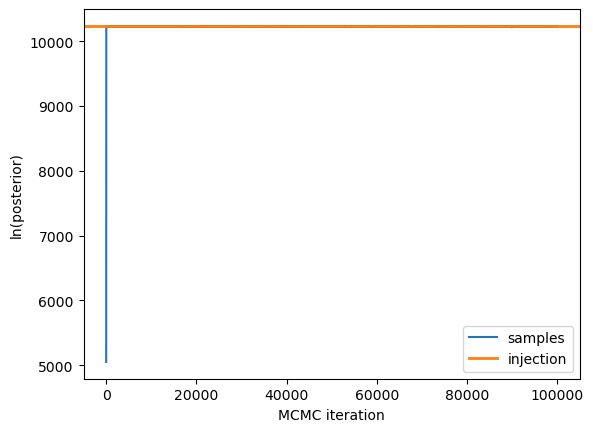

In [16]:
# plot posterior values of samples
plt.plot(ent_samples_dict['lnposts'], label='samples')
plt.axhline(pta.get_lnlikelihood(x_inj_dict) + pta.get_lnprior(x_inj_dict),
            color='C1', label='injection', lw=2)
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.legend()
plt.show()

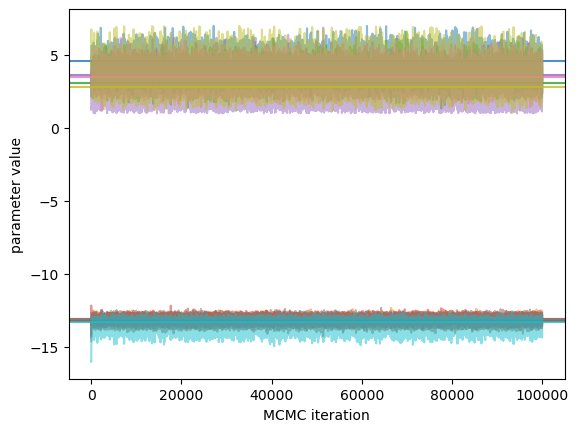

In [17]:
# make trace plot for parameters
for i, param_name in enumerate(pta.param_names):
    plt.plot(ent_samples_dict[param_name], color=f'C{i}', alpha=0.5)
    plt.axhline(x_inj_dict[param_name], color=f'C{i}',
                label=param_name, alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
# plt.legend()
plt.show()

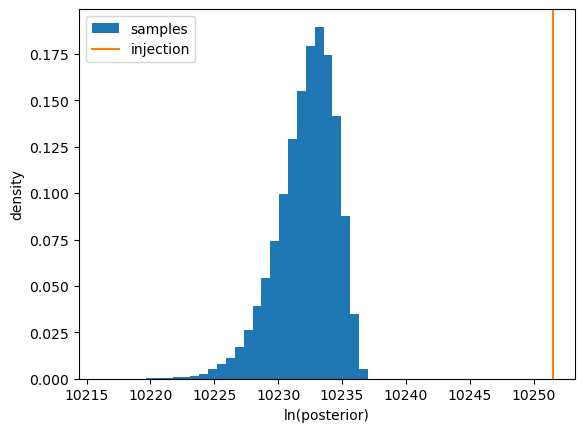

In [19]:
# histogram of posterior samples
plt.hist(ent_samples_dict['lnposts'][10_000:], bins=30,
         label='samples', density=True)
# plt.axvline(pta.get_lnlikelihood(x_inj_dict) + pta.get_lnprior(x_inj_dict),
#             color='C1', label='injection')
plt.axvline(pta.get_lnlikelihood(x_inj_dict),
            color='C1', label='injection')
plt.xlabel('ln(posterior)')
plt.ylabel('density')
plt.legend()
plt.show()

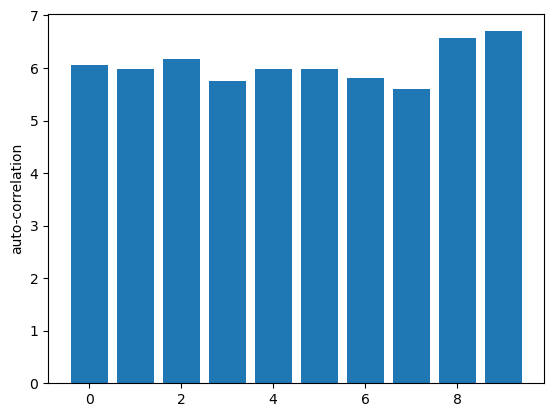

In [21]:
# auto-correlation
auto_corrs = [integrated_time(ent_samples_dict[name])[0]
              for name in pta.param_names]
plt.bar(np.arange(len(pta.param_names)), auto_corrs)
plt.ylabel('auto-correlation')
plt.show()

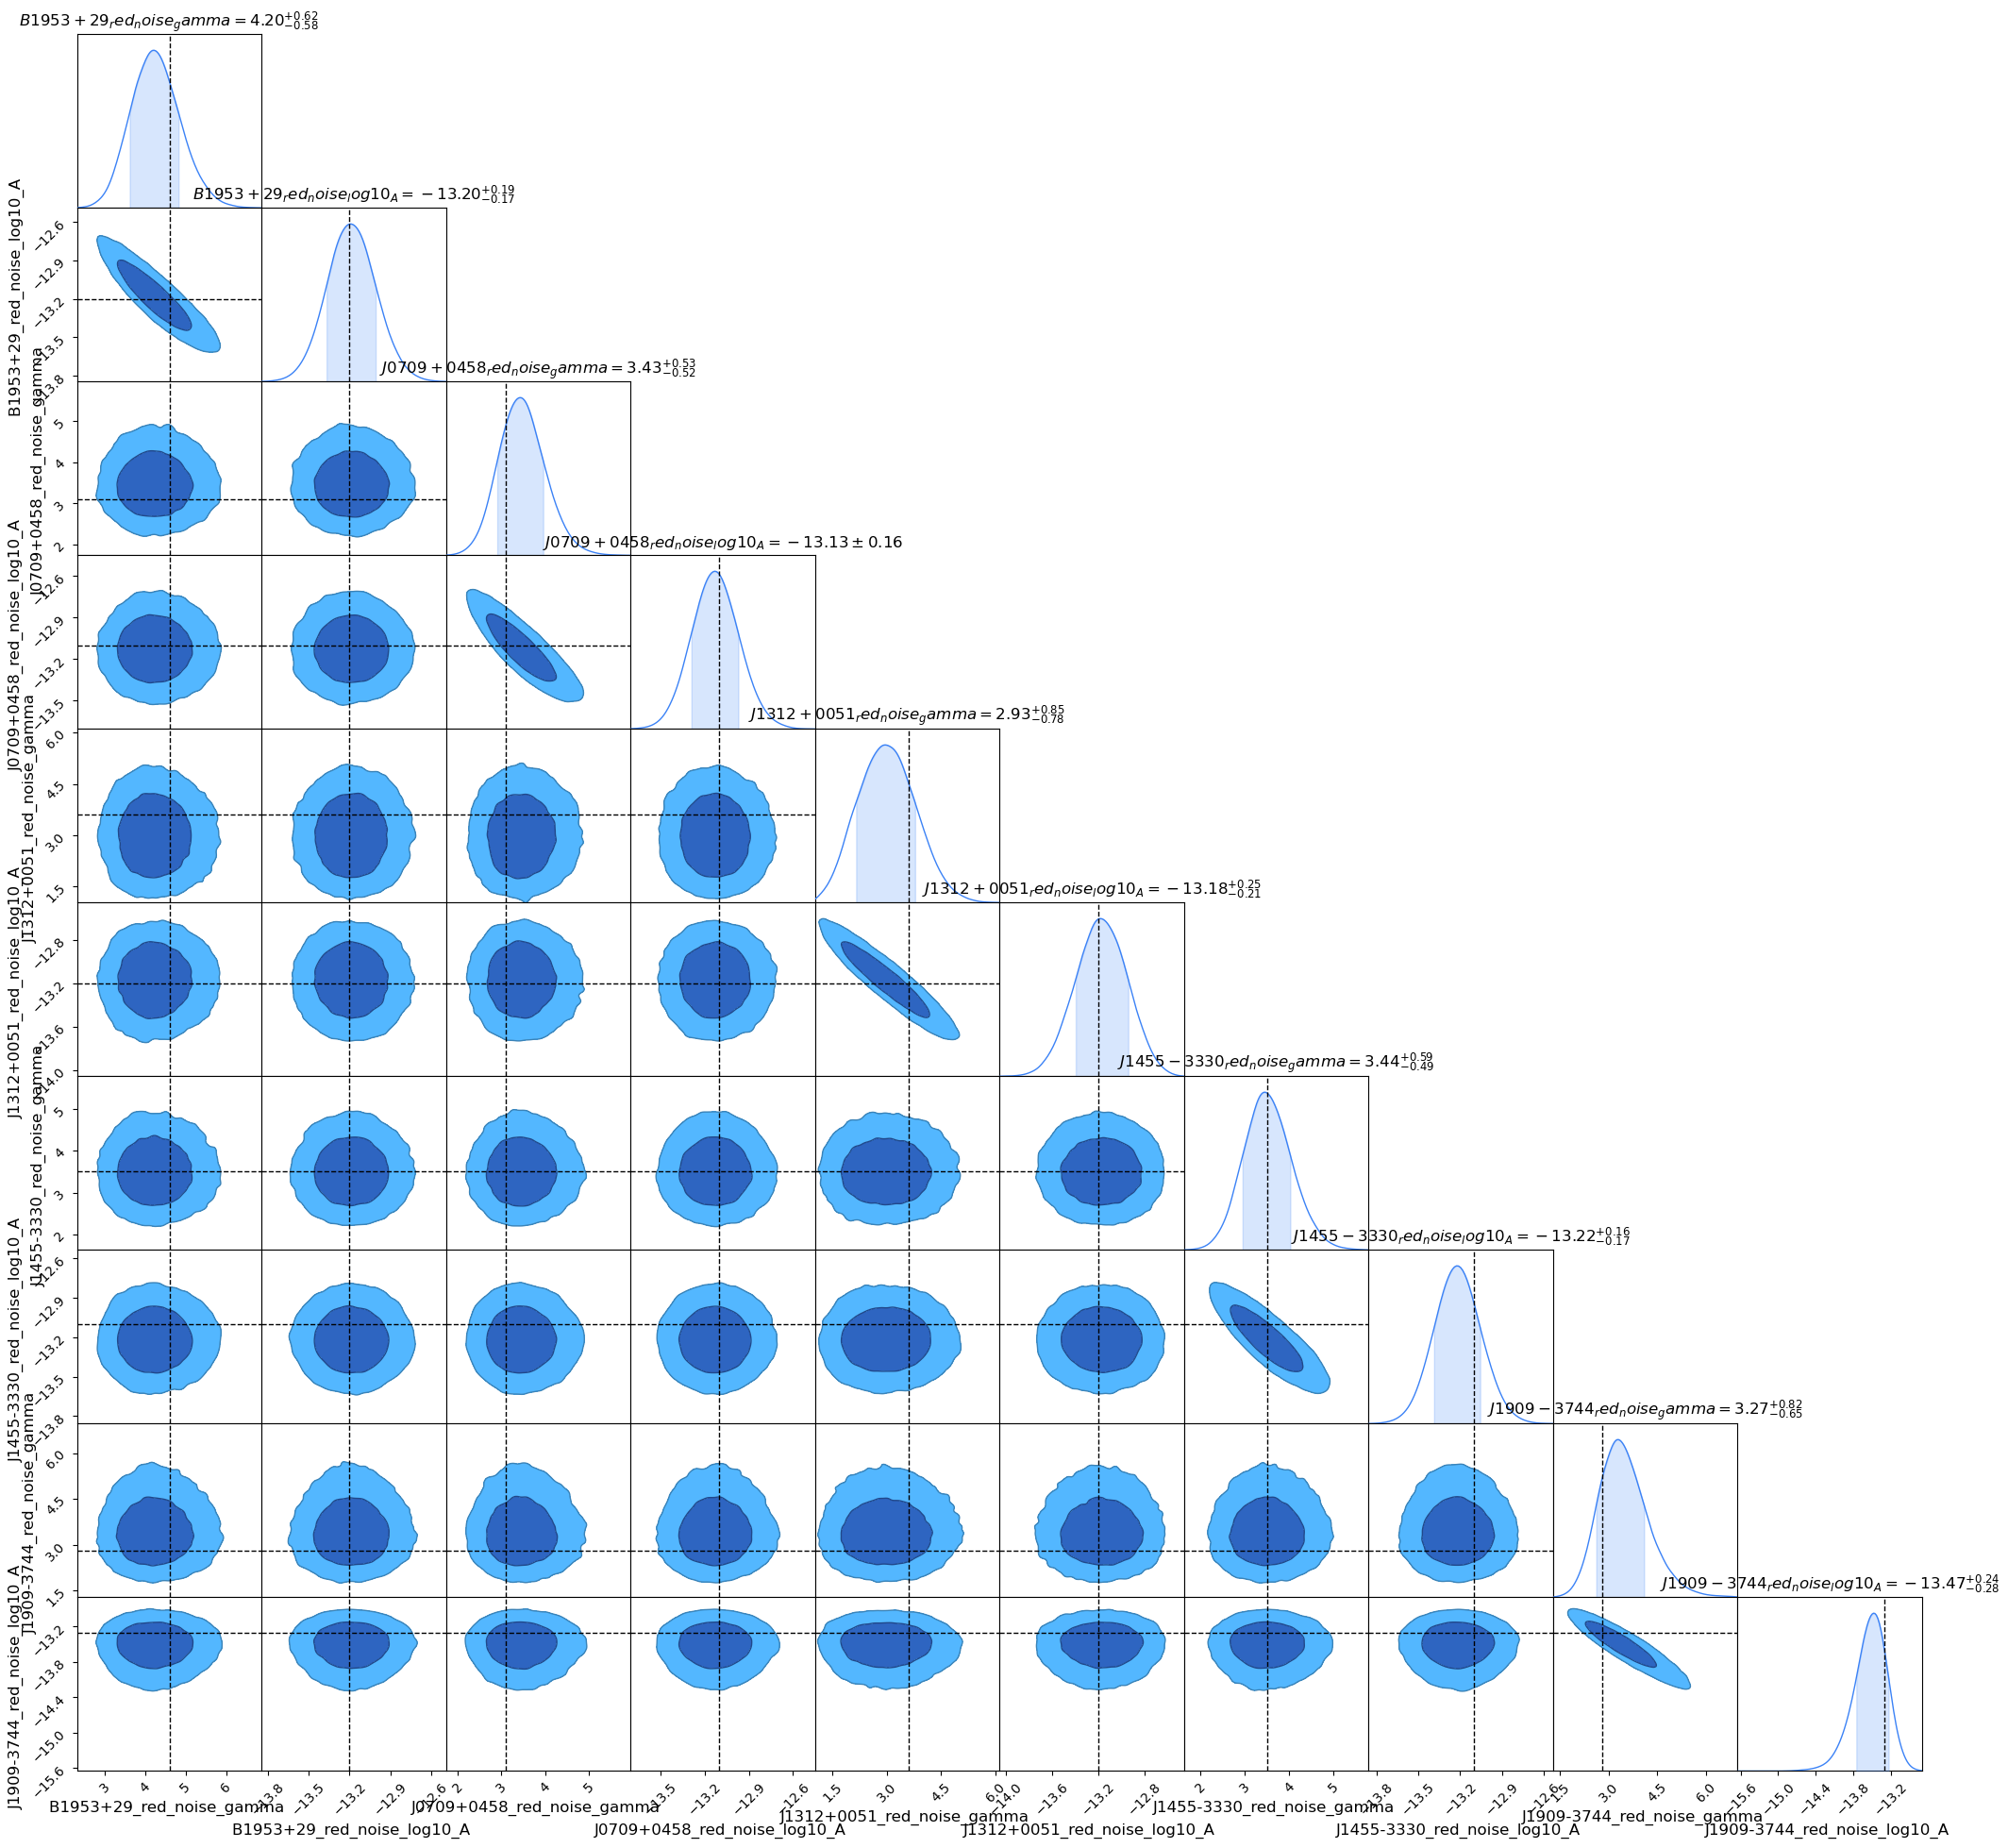

In [18]:
# corner plot
ndxs = np.r_[:10]
ent_df = pd.DataFrame(ent_samples_dict)
c = ChainConsumer()
c.add_chain(Chain(samples=ent_df.iloc[:, ndxs], name='Enterprise'))
c.add_truth(Truth(location=x_inj_dict))
fig = c.plotter.plot()